In [18]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber
from utils import get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Visualization Testing

In [20]:
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
action = ''

In [21]:
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = BoardVisualization(board)


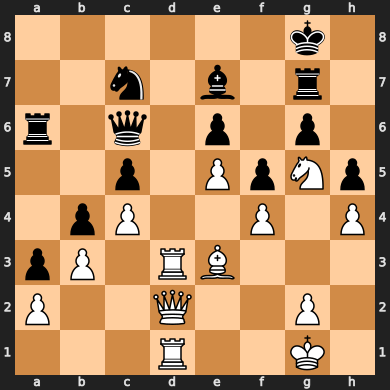

In [22]:
board_visualization.only_board()

# Sarfa (without defined action)

In [26]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    saliency, optimal_action = saliency_calculator.compute(perturbed_board, None)
    saliency_results[perturbed_position_str] = saliency
    print(f"{perturbed_position_str} removed: {saliency}")

a2 removed: 0.3998791338277637
a3 removed: 0.5282240717473276
a6 removed: 0.17684001949463948
b3 removed: 0.40302937042847253
b4 removed: 0.5096363468544408
c4 removed: 0.44575468015922154
c5 removed: 0
c6 removed: 0.09291936714704815
c7 removed: 0.09119020565699339
d1 removed: 0.4022552350418561
d2 removed: 0.40862086528420843
d3 removed: 0.500388825014764
e3 removed: 0.4060207127457794
e5 removed: 0.39539583817603025
e6 removed: 0.2402070922602106
e7 removed: 0.1371710040812153
f4 removed: 0.33699800672004465
f5 removed: 0
g2 removed: 0.42415128400491775
g5 removed: 0.4039881172055799
g6 removed: 0.2648678899989088
g7 removed: 0.1403612721583611
h4 removed: 0.2885312797921649
h5 removed: 0.2964447611935855


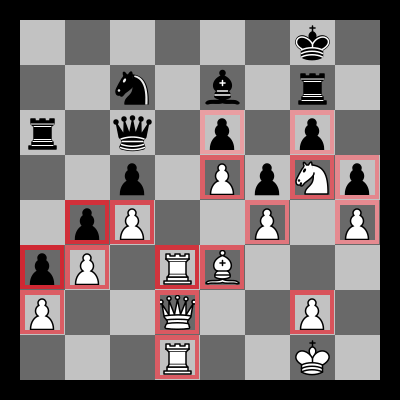

In [27]:
path = board_visualization.show_heatmap(saliency_results, optimal_action)
display(Image(path))

# Sarfa Baseline with Move

In [28]:
action: chess.Move = chess.Move.from_uci("e3f2")

In [36]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board, runtime=2)
for perturbed_board, perturbed_position_str in perturber.process():

    saliency, _ = saliency_calculator.compute(perturbed_board, action)
    saliency_results[perturbed_position_str] = saliency


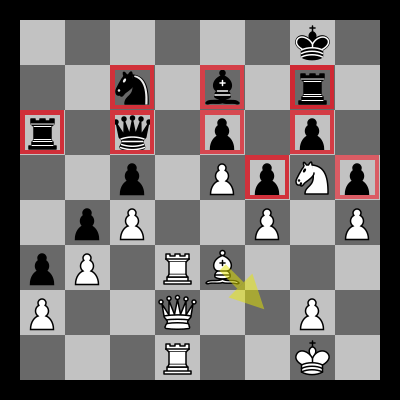

In [37]:
path = board_visualization.show_heatmap(saliency_results, action)
display(Image(path))

# Benchmarking

In [38]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [44]:
def saliency_algorithm(fen, action=None) -> dict[str, float]:
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency, _ = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency

    return saliency_results


In [103]:
benchmark = SafraBenchmark(saliency_algorithm)

9
19
29
There is a saliency value that exists in the dataset ground truth which wasn't tested by the  algorithm: 
 2r1kr2/pR5p/2q5/3p4/Q3bP2/8/PP4PP/4R1K1 w - - 0 1 with pos: c6
39
49
59
69
There is a saliency value that exists in the dataset ground truth which wasn't tested by the  algorithm: 
 3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1 with pos: g7
79
89
99


In [104]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7066376726352244}

In [105]:
fpr, tpr = benchmark.roc_curve()
roc_auc = auc(fpr, tpr)


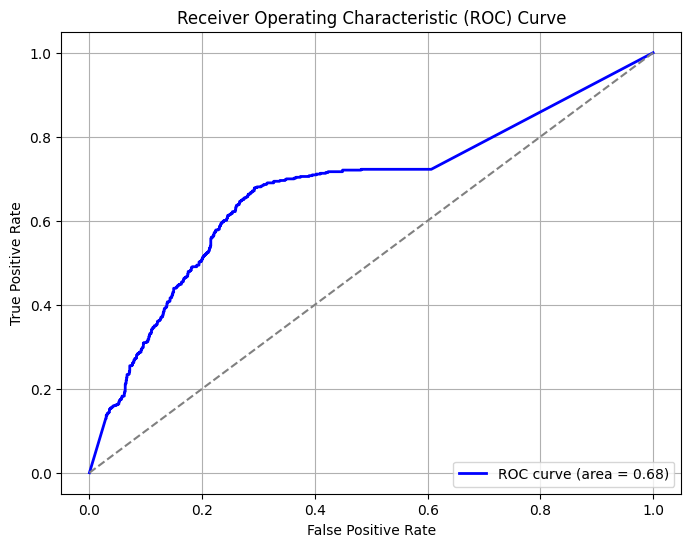

In [106]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Sequential SARFA

## Sanity Check

In [96]:
engine = Engine("./stockfish_15_x64_avx2")
saliency_results_per_step = []
actions = []

def sequential_saliency_algorithm(fen, discount_factor, depth):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board)
        
        for perturbed_board, perturbed_position_str in perturber.process():
            saliency, optimal_move_original_board = saliency_calculator.compute(perturbed_board, None)

            optimal_move = optimal_move_original_board
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (saliency * (discount_factor ** curr_step))
        
        saliency_results_per_step.append((saliency_results.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        actions.append(optimal_move_obj)
        board.push(optimal_move_obj)
        saliency_calculator.original_board_actions = set(board.legal_moves) 

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break



    return saliency_results

In [97]:
# fen = 'r2qrbk1/1bp2ppp/p2p1n2/2p2NB1/4P3/2N2Q2/PPP2PPP/R3R1K1 w - - 0 1
fen = "6k1/2n1b1r1/r1qRp1p1/2p1PpNp/1pP2P1P/pP2B3/P2Q2P1/3R2K1 w - - 0 1"
discount_factor = 0.9
depth = 3
saliency_results = sequential_saliency_algorithm(fen, discount_factor, depth)

curr step: 0
curr step: 1
curr step: 2


In [98]:
print(fen)

6k1/2n1b1r1/r1qRp1p1/2p1PpNp/1pP2P1P/pP2B3/P2Q2P1/3R2K1 w - - 0 1


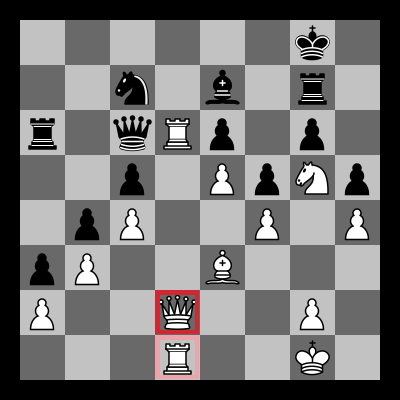

In [99]:
board_visualization = BoardVisualization(chess.Board(fen))
path = board_visualization.show_heatmap(saliency_results, None)
display(Image(path))

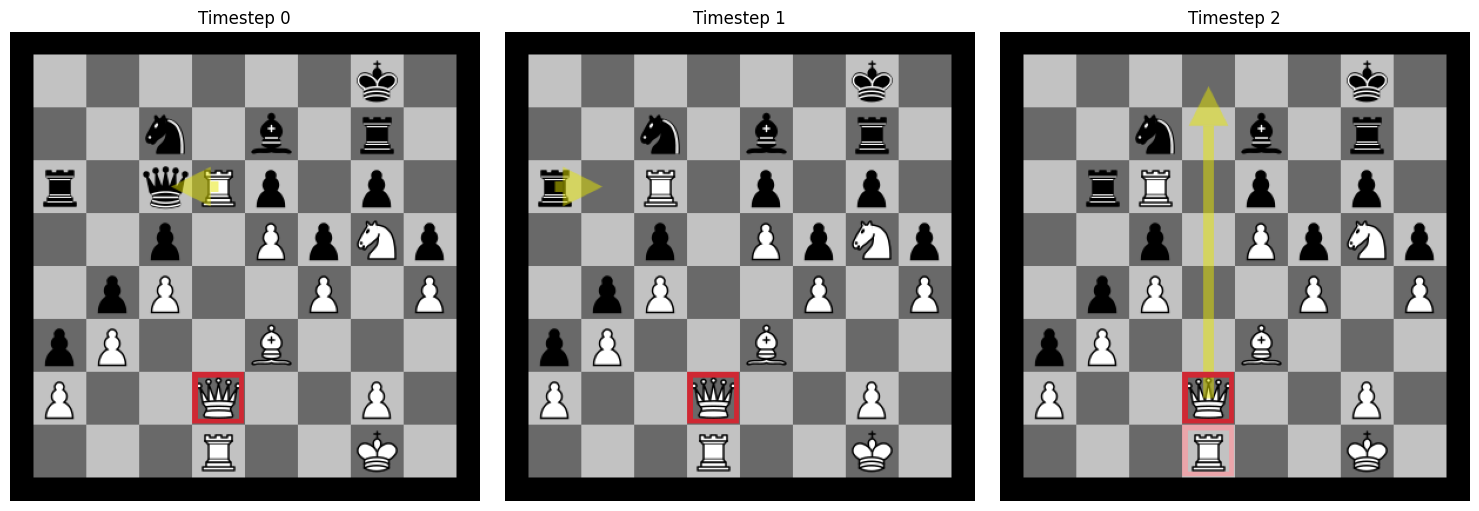

In [100]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, depth, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(depth):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], actions[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


In [107]:
benchmark = SafraBenchmark(lambda x, _: sequential_saliency_algorithm(x, 0.9, 3))

curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
9
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished early
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
19
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished ear

TypeError: object of type 'NoneType' has no len()